In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.wkt import loads
from shapely.geometry import Point
import os

import warnings
warnings.filterwarnings('ignore')

### Script Objectives:

This script filters our two main camera datasets (Amnesty Internation and Hikvision) via spatial joins on Brooklyn's shapefile. This will return a subset of the original camera datasets that we are interested in for our surviellance metric to be created for the neighborhoods across Brooklyn.

#### Input Files:

 **Cameras**

 * Amnesty International Cameras in Brookyln: `../Data/amnesty_international_cameras_brooklyn.csv`

 * Hikvision Cameras in Brooklyn: `../Data/hikvision_camera_brooklyn.csv`
 
  * Aggregated Camera Counts for NYC Census Tracts: `../Data/NYC_tracts_camera_aggregates.csv`


 **Shapefiles**

 * Brooklyn Census Blocks: `'../Data/BrooklynBlocks/BrooklynBlocks.shp'`

 * Brooklyn Census Tracts: `'../Data/BrooklynTracts/BrooklynTracts.shp'`

 * Brooklyn Census Block Groups: `../Data/BrooklynBlockGroups/BrooklynBlockGroups.shp`
 
 * Brooklyn Boundary Shapefile: `../Data/BrooklynBoundary.shp`
 

#### Output Files:

In [2]:
#read camera datasets
am_int = gpd.read_file('../Data/amnesty/amnesty_international_cameras_brooklyn.shp', index_col = 0)
hik = gpd.read_file('../Data/hikvision/hikvision_camera_brooklyn.shp', index_col = 0)

In [3]:
am_int.head()

PanoramaId  n_cameras_  attached_s  attached_b  attached_u  \
0  --kQB7vdISN5ZhBDo82BHg           0           0           0           0   
1  -0Kgxt4Lfda78gY2WuEMqA           0           0           0           0   
2  -0KlvkzMEDcLyTePpuY3sg           5           0           5           0   
3  -0Y6fGJQcnKZ-crSKaVIfQ           0           0           0           0   
4  -0yXEvW841dBjrs54VZKIA           0           0           0           0   

   type_dome_  type_bulle  type_unkno    n_camera_1 attached_1  ...  \
0           0           0           0        2 vs 1  Unanimous  ...   
1           0           0           0        2 vs 1     2 vs 1  ...   
2           0           0           0  All disagree  Unanimous  ...   
3           0           0           0        2 vs 1  Unanimous  ...   
4           0           0           0        2 vs 1  Unanimous  ...   

  type_dom_1 type_bul_1 type_unk_1        Lat       Long  \
0  Unanimous  Unanimous  Unanimous  40.706633 -73.935702   
1  Unanimous  Unanimous     2 vs 1  40.639826 -73.897770   
2  Unanimous  Unanimous  Unanimous  40.692888 -73.956733   
3  Unanimous  Unanimous  Unanimous  40.662758 -73.885122   
4  Unanimous  Unanimous  Unanimous  40.655396 -74.003186   

                                     geometry_p  BoroName  \
0  POINT (-73.93570246701009 40.70663303266096)  Brooklyn   
1  POINT (-73.89777023441276 40.63982610941098)  Brooklyn   
2  POINT (-73.95673315914595 40.69288765636261)  Brooklyn   
3  POINT (-73.88512163867377 40.66275783316144)  Brooklyn   
4  POINT (-74.00318577678686 40.65539642907692)  Brooklyn   

                                                 URL ImageDate  \
0  https://www.google.com/maps/@?api=1&map_action...   2020-11   
1  https://www.google.com/maps/@?api=1&map_action...   2018-06   
2  https://www.google.com/maps/@?api=1&map_action...   2020-11   
3  https://www.google.com/maps/@?api=1&map_action...   2018-06   
4  https://www.google.com/maps/@?api=1&map_action...   2019-06   

                     geometry  
0  POINT (-73.93570 40.70663)  
1  POINT (-73.89777 40.63983)  
2  POINT (-73.95673 40.69289)  
3  POINT (-73.88512 40.66276)  
4  POINT (-74.00319 40.65540)  

[5 rows x 22 columns]

In [4]:
am_int.columns

Index(['PanoramaId', 'n_cameras_', 'attached_s', 'attached_b', 'attached_u',
       'type_dome_', 'type_bulle', 'type_unkno', 'n_camera_1', 'attached_1',
       'attached_2', 'attached_3', 'type_dom_1', 'type_bul_1', 'type_unk_1',
       'Lat', 'Long', 'geometry_p', 'BoroName', 'URL', 'ImageDate',
       'geometry'],
      dtype='object')

In [5]:
print(len(am_int))
am_int = am_int[am_int['n_cameras_']> 0]
print(len(am_int))

10377
4662


<AxesSubplot:>

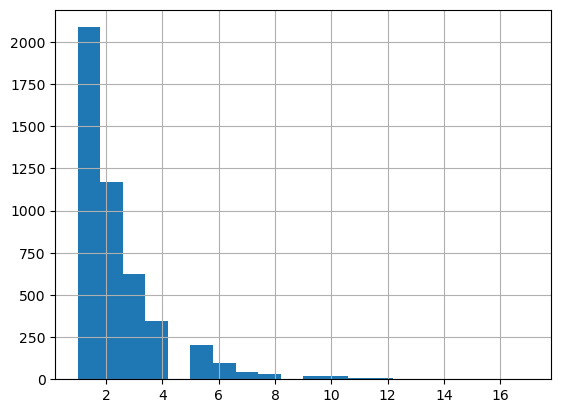

In [6]:
am_int['n_cameras_'].hist(bins = 20)

In [7]:
Coverage = []

for i in range(0,len(am_int)):
    if am_int.iloc[i]['n_cameras_'] == 1:
        Coverage.append('Single Camera')
    else:
        Coverage.append('Multiple Cameras')
am_int['Coverage'] = Coverage
am_int.head()

PanoramaId  n_cameras_  attached_s  attached_b  attached_u  \
2   -0KlvkzMEDcLyTePpuY3sg           5           0           5           0   
7   -3_J1noE14rnXJQAOutg0g           5           0           5           0   
10  -4FkkIbALjSxxgzxg-ssNg           1           0           0           0   
11  -4VW6uRzAgbhI_gYKrTxDQ           7           0           7           0   
15  -694MYTbjy9EXcMHPlP6lw           1           0           1           0   

    type_dome_  type_bulle  type_unkno    n_camera_1 attached_1  ...  \
2            0           0           0  All disagree  Unanimous  ...   
7            0           0           0  All disagree  Unanimous  ...   
10           0           0           0  All disagree  Unanimous  ...   
11           0           0           0        2 vs 1  Unanimous  ...   
15           0           0           0  All disagree  Unanimous  ...   

   type_bul_1 type_unk_1        Lat       Long  \
2   Unanimous  Unanimous  40.692888 -73.956733   
7   Unanimous  Unanimous  40.629372 -73.972852   
10  Unanimous  Unanimous  40.706149 -73.965655   
11  Unanimous  Unanimous  40.672012 -73.903590   
15  Unanimous  Unanimous  40.675751 -73.959759   

                                      geometry_p  BoroName  \
2   POINT (-73.95673315914595 40.69288765636261)  Brooklyn   
7                   POINT (-73.972852 40.629372)  Brooklyn   
10                POINT (-73.9656547 40.7061494)  Brooklyn   
11  POINT (-73.90359040904946 40.67201210342986)  Brooklyn   
15  POINT (-73.95975884133387 40.67575133866482)  Brooklyn   

                                                  URL ImageDate  \
2   https://www.google.com/maps/@?api=1&map_action...   2020-11   
7   https://www.google.com/maps/@?api=1&map_action...   2020-11   
10  https://www.google.com/maps/@?api=1&map_action...   2020-11   
11  https://www.google.com/maps/@?api=1&map_action...   2019-07   
15  https://www.google.com/maps/@?api=1&map_action...   2020-11   

                      geometry          Coverage  
2   POINT (-73.95673 40.69289)  Multiple Cameras  
7   POINT (-73.97285 40.62937)  Multiple Cameras  
10  POINT (-73.96565 40.70615)     Single Camera  
11  POINT (-73.90359 40.67201)  Multiple Cameras  
15  POINT (-73.95976 40.67575)     Single Camera  

[5 rows x 23 columns]

In [8]:
hik.head()

Name   Latitude  Longitude  Zip_Code   Borough  \
0  100.12.110.237  40.694599 -73.990639   11201.0  Brooklyn   
1    100.2.171.33  40.694599 -73.990639   11201.0  Brooklyn   
2   100.2.223.120  40.694599 -73.990639   11201.0  Brooklyn   
3   100.2.223.225  40.694599 -73.990639   11201.0  Brooklyn   
4  100.33.242.212  40.702461 -73.987801   11201.0  Brooklyn   

                           geometry_l                                   wkt  \
0  Hikvision: Brooklyn (Layer 1 of 3)  POINT Z (-73.99063873 40.69459915 0)   
1  Hikvision: Brooklyn (Layer 1 of 3)  POINT Z (-73.99063873 40.69459915 0)   
2  Hikvision: Brooklyn (Layer 1 of 3)  POINT Z (-73.99063873 40.69459915 0)   
3  Hikvision: Brooklyn (Layer 1 of 3)  POINT Z (-73.99063873 40.69459915 0)   
4  Hikvision: Brooklyn (Layer 1 of 3)   POINT Z (-73.9878006 40.70246124 0)   

                     geometry  
0  POINT (-73.99064 40.69460)  
1  POINT (-73.99064 40.69460)  
2  POINT (-73.99064 40.69460)  
3  POINT (-73.99064 40.69460)  
4  POINT (-73.98780 40.70246)

In [9]:
zipcode_shp = gpd.read_file('../Data/ZIP_CODE_040114/ZIP_CODE_040114.SHP')
zipcode_shp.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.252 188138.380, 1038141.936 ...  
1  POLYGON ((1001613.713 186926.440, 1002314.243 ...  
2  POLYGON ((1011174.276 183696.338, 1011373.584 ...  
3  POLYGON ((995908.365 183617.613, 996522.848 18...  
4  POLYGON ((991997.113 176307.496, 992042.798 17...

In [10]:
bkzips = zipcode_shp[zipcode_shp['COUNTY'] == 'Kings']
bkzips = bkzips.to_crs('4326')

In [11]:
directory = "../Data/BrooklynZipCodes"

if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory created successfully")
else:
    print("Directory already exists")

bkzips.to_file('../Data/BrooklynZipCodes/BrooklynZipCodes.shp')

Directory already exists


In [12]:
bkzips['coords'] = bkzips['geometry'].apply(lambda x: x.representative_point().coords[:])
bkzips['coords'] = [coords[0] for coords in bkzips['coords']]

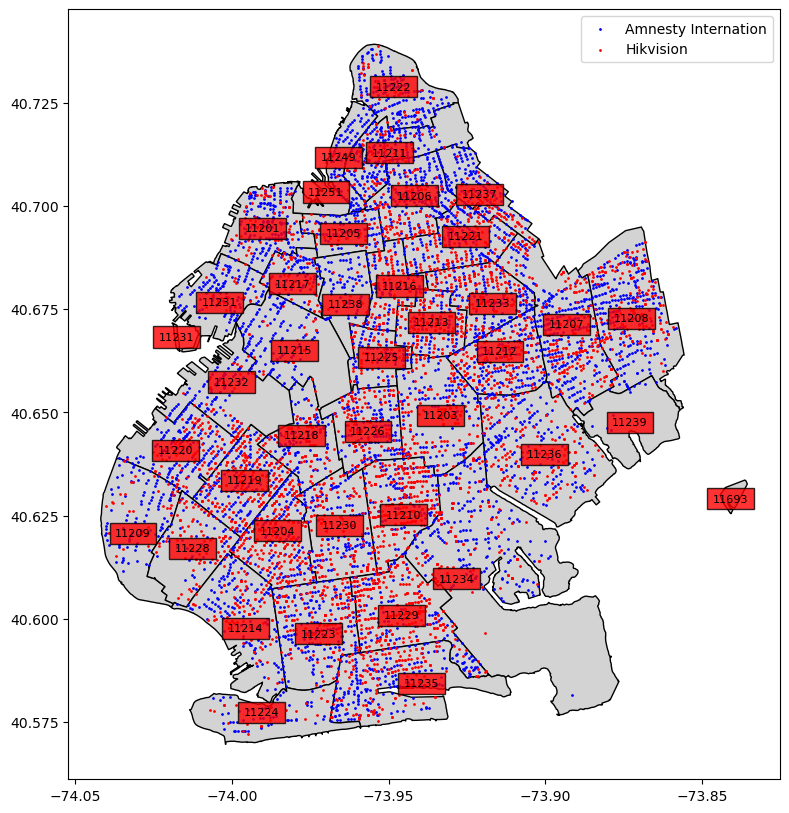

In [13]:
fig, ax = plt.subplots(figsize = (10,10))
bkzips.plot(ax = ax, color = 'lightgrey',edgecolor = 'black')
am_int.plot(ax = ax, color = 'b', markersize = 1, label = 'Amnesty Internation', legend = True)
hik.plot(ax = ax, color = 'r', markersize = 1, label = 'Hikvision', legend = True)

for idx, row in bkzips.iterrows():
    plt.text(x = row['coords'][0],y = row['coords'][1], s = row['ZIPCODE'],
             ha='center',va='center', color='black', fontsize = 8,bbox={'facecolor': 'red', 'alpha': 0.8})

ax.legend()

In [14]:
## create buffer zone around camera point locations
#add 120m around each shape
am_int = am_int.to_crs('EPSG:32118') # Use an appropriate projected system for your area
am_int['buffer_distance'] = 120 # in meters
buffered_gdf = pd.DataFrame()

for index, row in am_int.iterrows():
    polygon = row.geometry
    buffer_distance = row.buffer_distance
    buffered_polygon = polygon.buffer(buffer_distance, cap_style=1)
    buffered_gdf = buffered_gdf.append({'geometry': buffered_polygon}, ignore_index=True)
    
am_int_buff = gpd.GeoDataFrame(buffered_gdf,crs = am_int.crs)
am_int_buff = am_int_buff.to_crs('EPSG:4326') # Use an appropriate projected system for your area

In [15]:
am_int_buff_120 = pd.merge(am_int.drop(columns=['geometry']),am_int_buff, left_index=True, right_index=True)
am_int_buff_120 = gpd.GeoDataFrame(am_int_buff_120,geometry = 'geometry', crs = 'EPSG:4326')
am_int_buff_120.head()

PanoramaId  n_cameras_  attached_s  attached_b  attached_u  \
2   -0KlvkzMEDcLyTePpuY3sg           5           0           5           0   
7   -3_J1noE14rnXJQAOutg0g           5           0           5           0   
10  -4FkkIbALjSxxgzxg-ssNg           1           0           0           0   
11  -4VW6uRzAgbhI_gYKrTxDQ           7           0           7           0   
15  -694MYTbjy9EXcMHPlP6lw           1           0           1           0   

    type_dome_  type_bulle  type_unkno    n_camera_1 attached_1  ...  \
2            0           0           0  All disagree  Unanimous  ...   
7            0           0           0  All disagree  Unanimous  ...   
10           0           0           0  All disagree  Unanimous  ...   
11           0           0           0        2 vs 1  Unanimous  ...   
15           0           0           0  All disagree  Unanimous  ...   

   type_unk_1        Lat       Long  \
2   Unanimous  40.692888 -73.956733   
7   Unanimous  40.629372 -73.972852   
10  Unanimous  40.706149 -73.965655   
11  Unanimous  40.672012 -73.903590   
15  Unanimous  40.675751 -73.959759   

                                      geometry_p  BoroName  \
2   POINT (-73.95673315914595 40.69288765636261)  Brooklyn   
7                   POINT (-73.972852 40.629372)  Brooklyn   
10                POINT (-73.9656547 40.7061494)  Brooklyn   
11  POINT (-73.90359040904946 40.67201210342986)  Brooklyn   
15  POINT (-73.95975884133387 40.67575133866482)  Brooklyn   

                                                  URL  ImageDate  \
2   https://www.google.com/maps/@?api=1&map_action...    2020-11   
7   https://www.google.com/maps/@?api=1&map_action...    2020-11   
10  https://www.google.com/maps/@?api=1&map_action...    2020-11   
11  https://www.google.com/maps/@?api=1&map_action...    2019-07   
15  https://www.google.com/maps/@?api=1&map_action...    2020-11   

            Coverage buffer_distance  \
2   Multiple Cameras             120   
7   Multiple Cameras             120   
10     Single Camera             120   
11  Multiple Cameras             120   
15     Single Camera             120   

                                             geometry  
2   POLYGON ((-73.96423 40.70615, -73.96424 40.706...  
7   POLYGON ((-73.93833 40.57824, -73.93834 40.578...  
10  POLYGON ((-73.94401 40.65900, -73.94402 40.658...  
11  POLYGON ((-73.92101 40.59024, -73.92102 40.590...  
15  POLYGON ((-73.92927 40.69151, -73.92927 40.691...  

[5 rows x 24 columns]

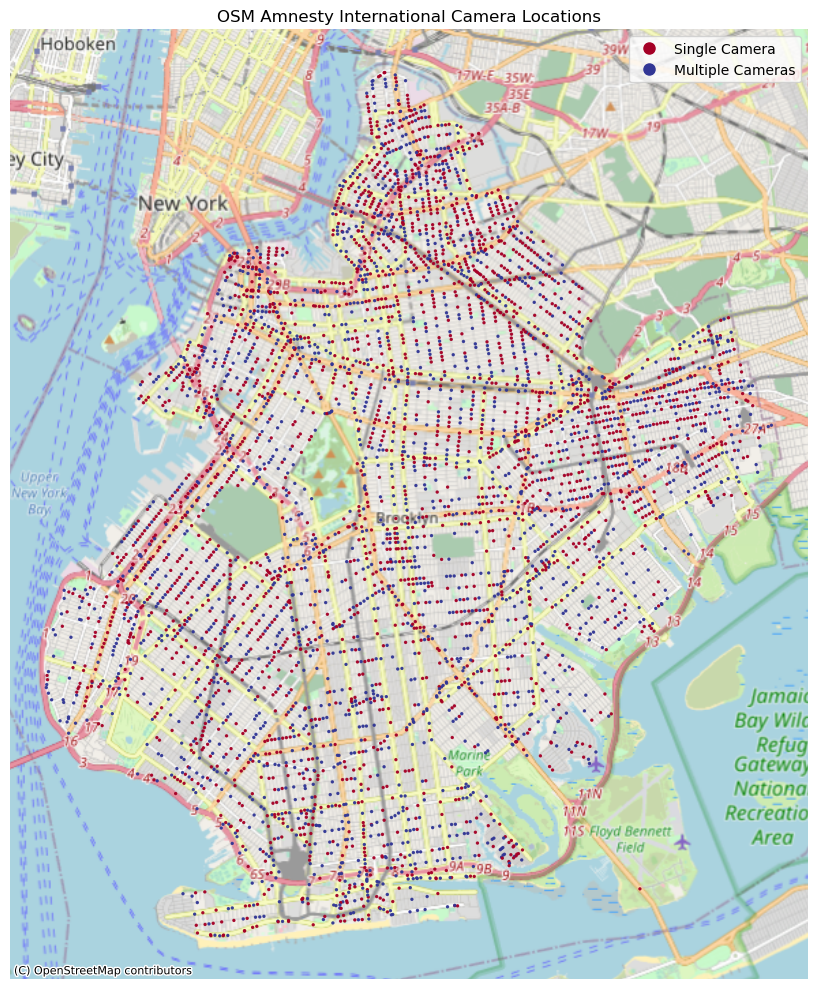

In [16]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Single Camera', 'B': 'Multiple Cameras'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
am_int.plot(column='Coverage', alpha=0.9, markersize=2, cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add a title to the plot
ax.set_title('Coverage Map')

# add the basemap using contextily
ctx.add_basemap(ax, crs=am_int.crs.to_string(),source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.tight_layout()
plt.title('OSM Amnesty International Camera Locations')
plt.savefig('../Outputs/OSM_AmnInternation_BK_CameraLocs.png')


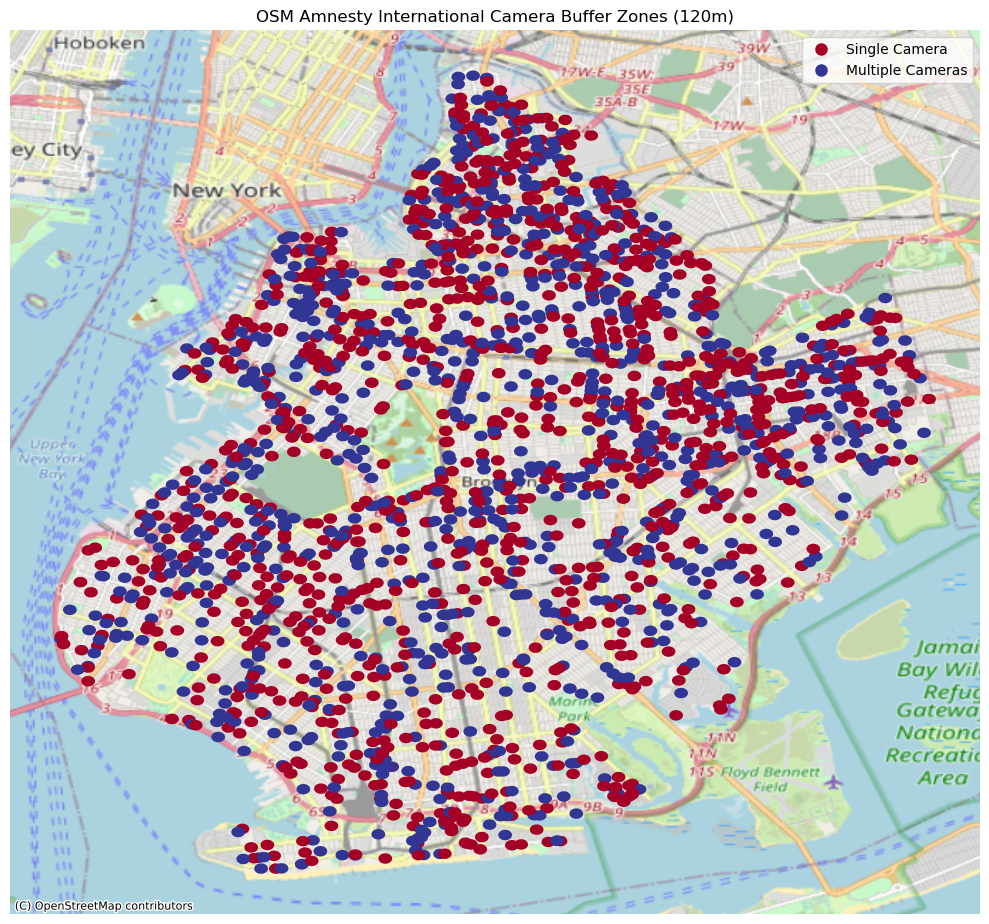

In [17]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Single Camera', 'B': 'Multiple Cameras'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
am_int_buff_120.plot(column='Coverage', cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add the basemap using contextily
ctx.add_basemap(ax, crs=am_int_buff_120.crs.to_string(),source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.tight_layout()
plt.title('OSM Amnesty International Camera Buffer Zones (120m)')
plt.savefig('../Outputs/OSM_AmnInternation_BK_CameraBuffer_120m.png')

In [18]:
## create buffer zone around camera point locations
#add 200m around each shape
am_int = am_int.to_crs('EPSG:32118') # Use an appropriate projected system for your area
am_int['buffer_distance'] = 200 # in meters
buffered_gdf = pd.DataFrame()

for index, row in am_int.iterrows():
    polygon = row.geometry
    buffer_distance = row.buffer_distance
    buffered_polygon = polygon.buffer(buffer_distance, cap_style=1)
    buffered_gdf = buffered_gdf.append({'geometry': buffered_polygon}, ignore_index=True)
    
am_int_buff = gpd.GeoDataFrame(buffered_gdf,crs = am_int.crs)
am_int_buff = am_int_buff.to_crs('EPSG:4326') # Use an appropriate projected system for your area

In [19]:
am_int.head()

PanoramaId  n_cameras_  attached_s  attached_b  attached_u  \
2   -0KlvkzMEDcLyTePpuY3sg           5           0           5           0   
7   -3_J1noE14rnXJQAOutg0g           5           0           5           0   
10  -4FkkIbALjSxxgzxg-ssNg           1           0           0           0   
11  -4VW6uRzAgbhI_gYKrTxDQ           7           0           7           0   
15  -694MYTbjy9EXcMHPlP6lw           1           0           1           0   

    type_dome_  type_bulle  type_unkno    n_camera_1 attached_1  ...  \
2            0           0           0  All disagree  Unanimous  ...   
7            0           0           0  All disagree  Unanimous  ...   
10           0           0           0  All disagree  Unanimous  ...   
11           0           0           0        2 vs 1  Unanimous  ...   
15           0           0           0  All disagree  Unanimous  ...   

   type_unk_1        Lat       Long  \
2   Unanimous  40.692888 -73.956733   
7   Unanimous  40.629372 -73.972852   
10  Unanimous  40.706149 -73.965655   
11  Unanimous  40.672012 -73.903590   
15  Unanimous  40.675751 -73.959759   

                                      geometry_p  BoroName  \
2   POINT (-73.95673315914595 40.69288765636261)  Brooklyn   
7                   POINT (-73.972852 40.629372)  Brooklyn   
10                POINT (-73.9656547 40.7061494)  Brooklyn   
11  POINT (-73.90359040904946 40.67201210342986)  Brooklyn   
15  POINT (-73.95975884133387 40.67575133866482)  Brooklyn   

                                                  URL  ImageDate  \
2   https://www.google.com/maps/@?api=1&map_action...    2020-11   
7   https://www.google.com/maps/@?api=1&map_action...    2020-11   
10  https://www.google.com/maps/@?api=1&map_action...    2020-11   
11  https://www.google.com/maps/@?api=1&map_action...    2019-07   
15  https://www.google.com/maps/@?api=1&map_action...    2020-11   

                        geometry          Coverage buffer_distance  
2   POINT (303657.098 58435.534)  Multiple Cameras             200  
7   POINT (302296.858 51381.723)  Multiple Cameras             200  
10  POINT (302902.429 59907.890)     Single Camera             200  
11  POINT (308151.517 56120.941)  Multiple Cameras             200  
15  POINT (303402.230 56532.460)     Single Camera             200  

[5 rows x 24 columns]

In [20]:
am_int_buff.head()

geometry
0  POLYGON ((-73.95437 40.69289, -73.95438 40.692...
1  POLYGON ((-73.97049 40.62937, -73.97050 40.629...
2  POLYGON ((-73.96329 40.70615, -73.96330 40.705...
3  POLYGON ((-73.90122 40.67201, -73.90124 40.671...
4  POLYGON ((-73.95739 40.67575, -73.95740 40.675...

In [21]:
am_int_buff_200 = pd.merge(am_int.drop(columns=['geometry']),am_int_buff, left_index=True, right_index=True)
am_int_buff_200 = gpd.GeoDataFrame(am_int_buff_200,geometry = 'geometry', crs = 'EPSG:4326')
am_int_buff_200.head()

PanoramaId  n_cameras_  attached_s  attached_b  attached_u  \
2   -0KlvkzMEDcLyTePpuY3sg           5           0           5           0   
7   -3_J1noE14rnXJQAOutg0g           5           0           5           0   
10  -4FkkIbALjSxxgzxg-ssNg           1           0           0           0   
11  -4VW6uRzAgbhI_gYKrTxDQ           7           0           7           0   
15  -694MYTbjy9EXcMHPlP6lw           1           0           1           0   

    type_dome_  type_bulle  type_unkno    n_camera_1 attached_1  ...  \
2            0           0           0  All disagree  Unanimous  ...   
7            0           0           0  All disagree  Unanimous  ...   
10           0           0           0  All disagree  Unanimous  ...   
11           0           0           0        2 vs 1  Unanimous  ...   
15           0           0           0  All disagree  Unanimous  ...   

   type_unk_1        Lat       Long  \
2   Unanimous  40.692888 -73.956733   
7   Unanimous  40.629372 -73.972852   
10  Unanimous  40.706149 -73.965655   
11  Unanimous  40.672012 -73.903590   
15  Unanimous  40.675751 -73.959759   

                                      geometry_p  BoroName  \
2   POINT (-73.95673315914595 40.69288765636261)  Brooklyn   
7                   POINT (-73.972852 40.629372)  Brooklyn   
10                POINT (-73.9656547 40.7061494)  Brooklyn   
11  POINT (-73.90359040904946 40.67201210342986)  Brooklyn   
15  POINT (-73.95975884133387 40.67575133866482)  Brooklyn   

                                                  URL  ImageDate  \
2   https://www.google.com/maps/@?api=1&map_action...    2020-11   
7   https://www.google.com/maps/@?api=1&map_action...    2020-11   
10  https://www.google.com/maps/@?api=1&map_action...    2020-11   
11  https://www.google.com/maps/@?api=1&map_action...    2019-07   
15  https://www.google.com/maps/@?api=1&map_action...    2020-11   

            Coverage buffer_distance  \
2   Multiple Cameras             200   
7   Multiple Cameras             200   
10     Single Camera             200   
11  Multiple Cameras             200   
15     Single Camera             200   

                                             geometry  
2   POLYGON ((-73.96329 40.70615, -73.96330 40.705...  
7   POLYGON ((-73.93738 40.57824, -73.93740 40.578...  
10  POLYGON ((-73.94306 40.65900, -73.94308 40.658...  
11  POLYGON ((-73.92007 40.59024, -73.92008 40.590...  
15  POLYGON ((-73.92832 40.69151, -73.92833 40.691...  

[5 rows x 24 columns]

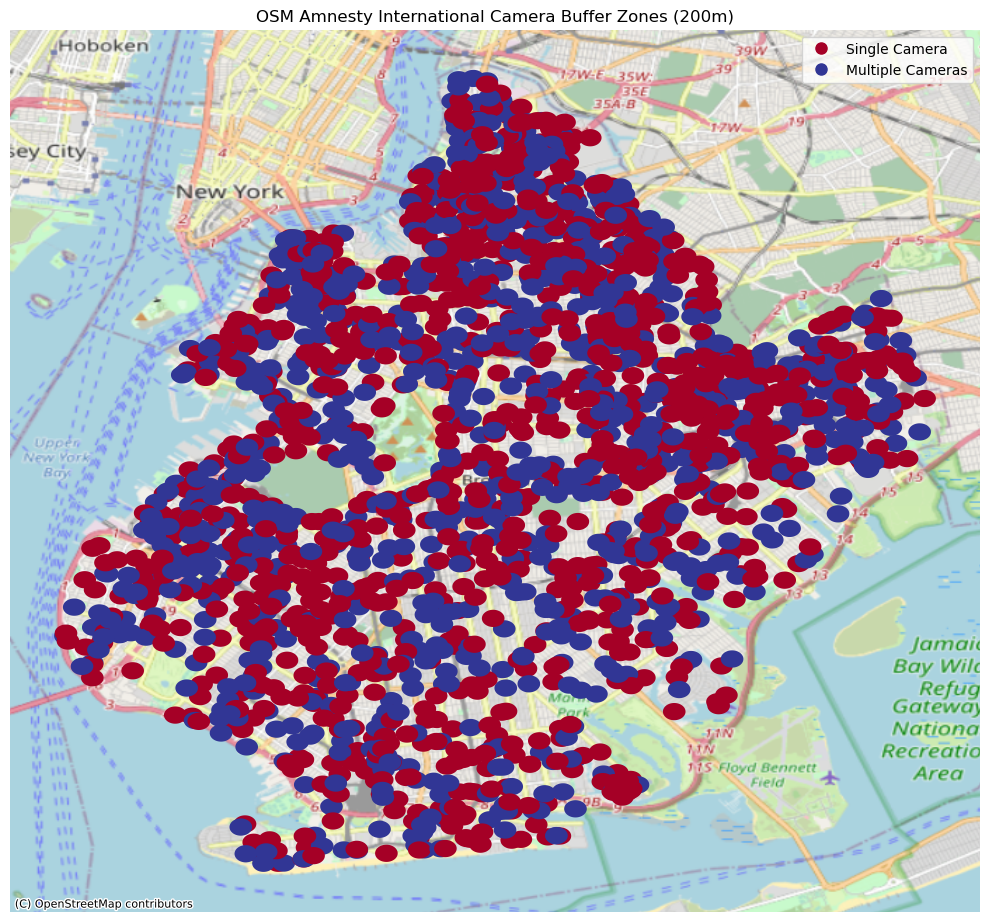

In [22]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Single Camera', 'B': 'Multiple Cameras'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
am_int_buff_200.plot(column='Coverage', cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add the basemap using contextily
ctx.add_basemap(ax, crs=am_int_buff_200.crs.to_string(),source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.tight_layout()
plt.title('OSM Amnesty International Camera Buffer Zones (200m)')
plt.savefig('../Outputs/OSM_AmnInternation_BK_CameraBuffer_200m.png')

# Lets look into the Map PLUTO data to incorporate building footprints as obstructions to the camera fields of view

Map PLUTO data is stored outside of the repository due to GitHub's file size constraints. The path to my data is as follows:

`path = os.getcwd()
parent = os.path.dirname(os.path.dirname(path))
mappluto = gpd.read_file(parent+'/CapstoneData/nyc_mappluto_22v2_shp/MapPLUTO.shp)
`

Please be sure to update this path if your data is stored in a different structure on your local device.

## [Introduction to MapPLUTO](https://nycplanning.github.io/db-pluto/#/)

The Primary Land Use Tax Lot Output (PLUTO™) data file contains extensive land use and geographic data at the tax lot level in a comma-delimited file. The PLUTO tax lot data files contain over seventy data fields derived from data files maintained by the Department of City Planning (DCP), Department of Finance (DOF), Department of Citywide Administrative Services (DCAS), and Landmarks Preservation Commission (LPC). DCP has created additional fields based on data obtained from one or more of the major data sources. PLUTO data files contain three basic types of data:

* Tax Lot Characteristics;
* Building Characteristics; and
* Geographic/Political/Administrative Districts.

In [23]:
#load camera data
path = os.getcwd()
parent = os.path.dirname(os.path.dirname(path))
print(parent)
mappluto = gpd.read_file(parent+'/CapstoneData/nyc_mappluto_22v2_shp/MapPLUTO.shp')

/Users/lizjohnson/Desktop/Personal_Projects


In [24]:
mappluto.head()

Borough  Block  Lot   CD  BCT2020    BCTCB2020 CT2010 CB2010 SchoolDist  \
0      MN      1  201  101  1000100  10001001000      1   1000         02   
1      MN      2    2  101  1000900  10009001022      9   1025         02   
2      MN      2   23  101  1000900  10009001022      9   1025         02   
3      MN      3    1  101  1001300  10013002002     13   2005         02   
4      MN      3    3  101  1000900  10009001019      9   1020         02   

   Council  ...  FIRM07_FLA PFIRM15_FL  Version  DCPEdited   Latitude  \
0        1  ...        None          1     22v2       None  40.698188   
1        1  ...           1          1     22v2       None  40.700550   
2        1  ...           1          1     22v2          t  40.701171   
3        1  ...           1          1     22v2       None  40.702806   
4        1  ...           1          1     22v2       None  40.701953   

   Longitude Notes Shape_Leng    Shape_Area  \
0 -74.041329  None        0.0  1.148539e+06   
1 -74.011588  None        0.0  8.724425e+04   
2 -74.009243  None        0.0  9.690237e+04   
3 -74.015631  None        0.0  9.214103e+05   
4 -74.013146  None        0.0  5.298613e+04   

                                            geometry  
0  POLYGON ((973648.661 193712.461, 973648.066 19...  
1  POLYGON ((980915.002 194319.141, 980795.371 19...  
2  MULTIPOLYGON (((981182.221 194851.167, 981181....  
3  MULTIPOLYGON (((980152.176 194762.899, 980089....  
4  POLYGON ((980713.169 194965.339, 980726.198 19...  

[5 rows x 95 columns]

In [25]:
mappluto.Borough.unique()

array(['MN', 'BX', 'BK', 'QN', 'SI'], dtype=object)

In [26]:
bk_mappluto = mappluto[mappluto['Borough'] == 'BK']
print(len(bk_mappluto),len(mappluto))

276096 857019


In [27]:
bk_mappluto.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

<AxesSubplot:>

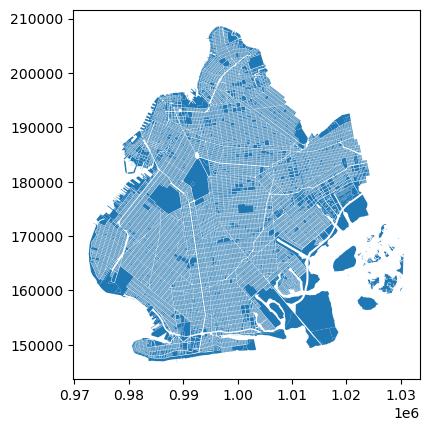

In [28]:
bk_mappluto.plot()

In [29]:
bk_mappluto = bk_mappluto[['BBL', 'CondoNo', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
                'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'XCoord', 'YCoord', 'Latitude',
               'Longitude', 'Shape_Leng', 'Shape_Area', 'geometry']].reset_index(drop = True)
bk_mappluto = bk_mappluto.to_crs(4326)
bk_mappluto.head()

BBL  CondoNo   CD  BCT2020    BCTCB2020 CT2010 CB2010 SchoolDist  \
0  3.000050e+09        0  302  3002100  30021003000     21   3001         13   
1  3.000070e+09        0  302  3002100  30021002016     21   2008         13   
2  3.000180e+09        0  302  3002100  30021002005     21   2002         13   
3  3.000200e+09        0  302  3002100  30021003001     21   3008         13   
4  3.000220e+09        0  302  3002100  30021003003     21   3006         13   

   Council  ZipCode  XCoord  YCoord   Latitude  Longitude  Shape_Leng  \
0       33    11201  989346  196266  40.705380 -73.981620         0.0   
1       33    11201  987216  195803  40.704110 -73.989303         0.0   
2       33    11201  987577  195811  40.704132 -73.988001         0.0   
3       33    11201  988375  195726  40.703898 -73.985123         0.0   
4       33    11201  989313  195784  40.704057 -73.981739         0.0   

      Shape_Area                                           geometry  
0  120860.134422  POLYGON ((-73.98090 40.70534, -73.98093 40.705...  
1   11203.671778  POLYGON ((-73.98907 40.70390, -73.98943 40.703...  
2   42751.332823  POLYGON ((-73.98836 40.70443, -73.98760 40.704...  
3   22750.376501  POLYGON ((-73.98553 40.70378, -73.98552 40.704...  
4   16121.487470  POLYGON ((-73.98147 40.70391, -73.98203 40.703...

In [ ]:
# Define the name and path of the folder you want to create
folder_name = "Brooklyn_MapPLUTO"
folder_path = "../Data/" + folder_name

# Check if the folder already exists and create it if it doesn't
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the name and path of the shapefile you want to save
shapefile_name = "BK_MapPLUTO_subset.shp"
shapefile_path = folder_path + "/" + shapefile_name

# Save the geodataframe to the shapefile
bk_mappluto.to_file(shapefile_path)

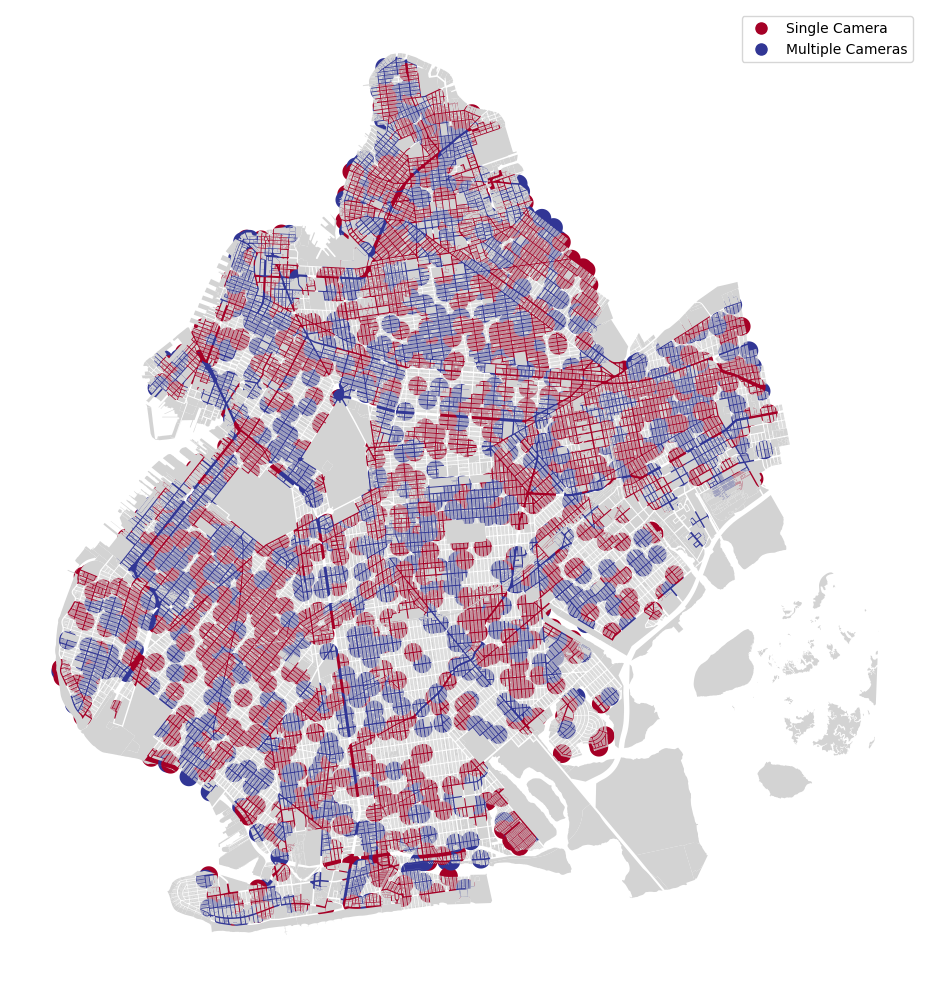

In [30]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Single Camera', 'B': 'Multiple Cameras'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
am_int_buff_200.plot(column='Coverage', cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add the basemap using contextily
bk_mappluto.plot(ax = ax, color = 'lightgrey')
plt.axis('off')
plt.tight_layout()

In [31]:
#load boundary file
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
#clip to bk_mappluto extent to remove the camera area outside of boundary
am_int_buff_200_clipped = am_int_buff_200.clip(bk_bndry)

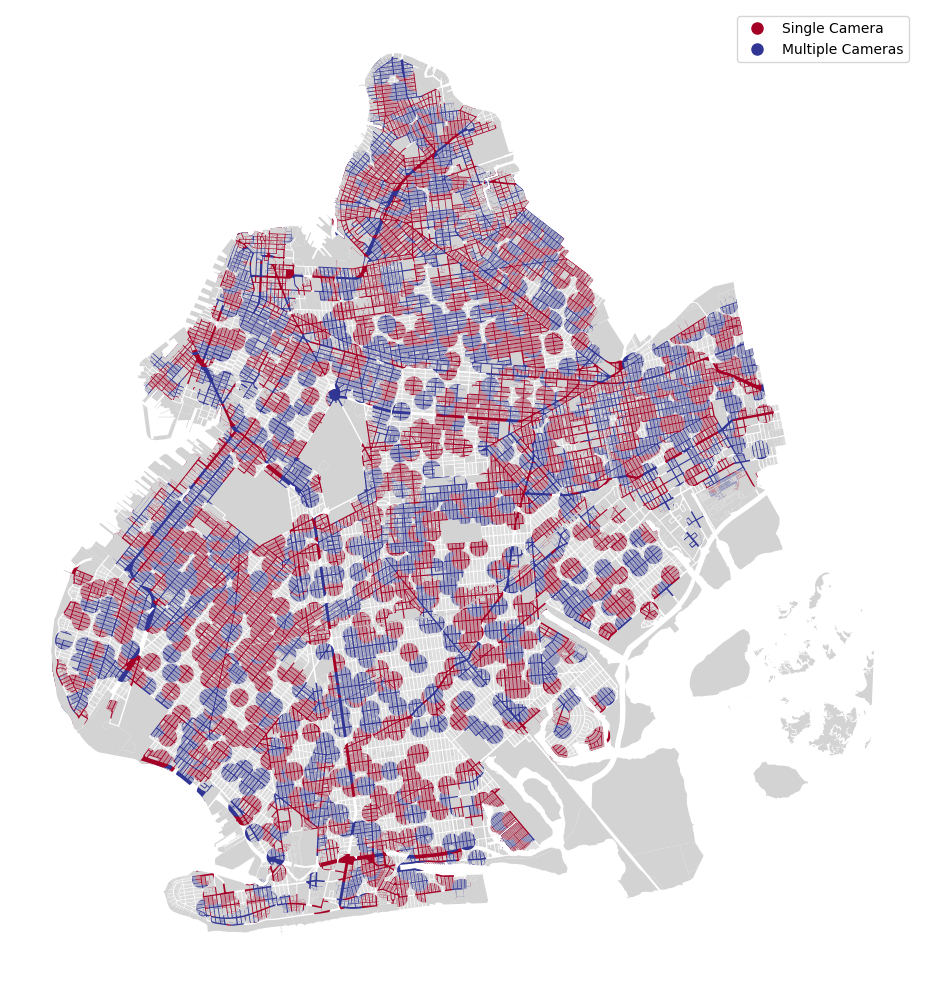

In [33]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Single Camera', 'B': 'Multiple Cameras'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
am_int_buff_200_clipped.plot(column='Coverage', cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add the basemap using contextily
bk_mappluto.plot(ax = ax, color = 'lightgrey')
plt.axis('off')
plt.tight_layout()

In [34]:
##lets take the difference of the 200m buffer geometry in comparison to the Brooklyn MapPLUTO geometry
# Calculate the difference between the two GeoDataFrames
street_surv_area = gpd.overlay(am_int_buff_200_clipped, bk_mappluto, how='difference')

In [35]:
street_surv_area.head()

PanoramaId  n_cameras_  attached_s  attached_b  attached_u  \
0  Jd1dOHXmSvUTS6BG5xArAg           1           0           1           0   
1  OHIh9Jkp5Xc6TqnEwALJmQ           1           0           1           0   
2  D5ian9sK2siY4HipPiLndg           2           0           2           0   
3  6NR_HkXDmLMgnBSRglGxUA           2           0           2           0   
4  J30OFm1YplM6woLB2wLiyw           7           0           2           0   

   type_dome_  type_bulle  type_unkno    n_camera_1 attached_1  ...  \
0           0           0           0  All disagree  Unanimous  ...   
1           0           0           0        2 vs 1  Unanimous  ...   
2           0           0           0        2 vs 1  Unanimous  ...   
3           0           0           0        2 vs 1     2 vs 1  ...   
4           0           0           0        2 vs 1     2 vs 1  ...   

  type_unk_1        Lat       Long  \
0  Unanimous  40.676461 -73.882314   
1  Unanimous  40.596190 -73.976423   
2  Unanimous  40.655667 -74.006682   
3  Unanimous  40.710724 -73.953584   
4  Unanimous  40.600793 -73.959617   

                                     geometry_p  BoroName  \
0  POINT (-73.88231447685956 40.67646087120924)  Brooklyn   
1   POINT (-73.97642257715559 40.5961897600551)  Brooklyn   
2  POINT (-74.00668186187765 40.65566650589307)  Brooklyn   
3   POINT (-73.9535835728477 40.71072418560068)  Brooklyn   
4  POINT (-73.95961731838118 40.60079328378103)  Brooklyn   

                                                 URL  ImageDate  \
0  https://www.google.com/maps/@?api=1&map_action...    2019-11   
1  https://www.google.com/maps/@?api=1&map_action...    2019-11   
2  https://www.google.com/maps/@?api=1&map_action...    2019-07   
3  https://www.google.com/maps/@?api=1&map_action...    2019-11   
4  https://www.google.com/maps/@?api=1&map_action...    2018-06   

           Coverage buffer_distance  \
0     Single Camera             200   
1     Single Camera             200   
2  Multiple Cameras             200   
3  Multiple Cameras             200   
4  Multiple Cameras             200   

                                            geometry  
0  MULTIPOLYGON (((-73.87703 40.66839, -73.87703 ...  
1  POLYGON ((-73.87024 40.66909, -73.87023 40.669...  
2  POLYGON ((-73.90765 40.66926, -73.90763 40.669...  
3  MULTIPOLYGON (((-73.91126 40.66879, -73.91138 ...  
4  MULTIPOLYGON (((-73.89674 40.67095, -73.89665 ...  

[5 rows x 24 columns]

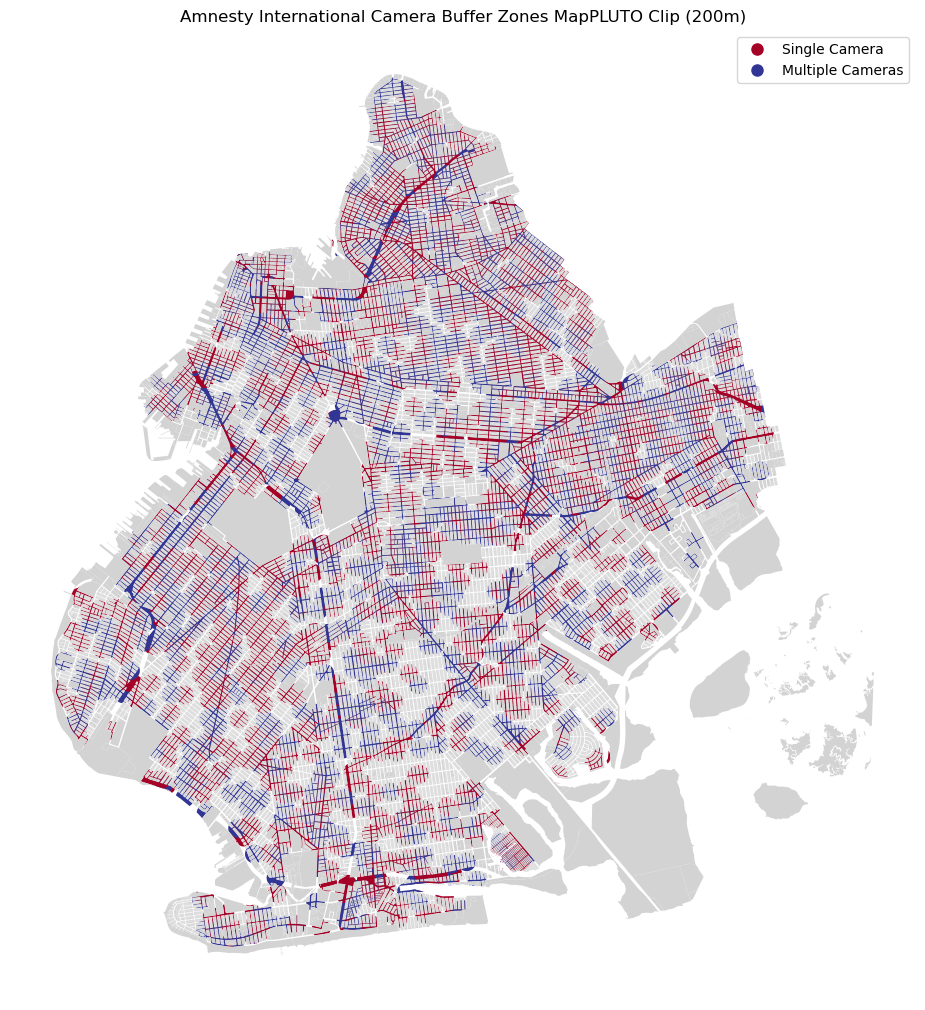

In [36]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Single Camera', 'B': 'Multiple Cameras'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
street_surv_area.plot(column='Coverage', cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add the basemap using contextily
bk_mappluto.plot(ax = ax, color = 'lightgrey')
plt.axis('off')
plt.tight_layout()
plt.title('Amnesty International Camera Buffer Zones MapPLUTO Clip (200m)')
plt.savefig('../Outputs/MapPLUTO_Clipped_AmnInternation_BK_CameraBuffer_200m.png')

### Follow up Questions for Team 4/11:

1. How do we want to account for multiple cameras in same intersection/location in our metric calculation?
    * add area for each camera regardless of location overlap?
    
    
2. How can we ensure the cameras within the Hikvision dataset are not the same as any camera in the amnesty international dataset?

In [37]:
#meter projection
street_surv_area = street_surv_area.to_crs(32118)
street_surv_area['area_km2'] = street_surv_area.geometry.area / 1e6
street_surv_area['area_cum'] = street_surv_area['area_km2']*street_surv_area['n_cameras_']
#re-project
street_surv_area = street_surv_area.to_crs(4326)
street_surv_area.head()

PanoramaId  n_cameras_  attached_s  attached_b  attached_u  \
0  Jd1dOHXmSvUTS6BG5xArAg           1           0           1           0   
1  OHIh9Jkp5Xc6TqnEwALJmQ           1           0           1           0   
2  D5ian9sK2siY4HipPiLndg           2           0           2           0   
3  6NR_HkXDmLMgnBSRglGxUA           2           0           2           0   
4  J30OFm1YplM6woLB2wLiyw           7           0           2           0   

   type_dome_  type_bulle  type_unkno    n_camera_1 attached_1  ...  \
0           0           0           0  All disagree  Unanimous  ...   
1           0           0           0        2 vs 1  Unanimous  ...   
2           0           0           0        2 vs 1  Unanimous  ...   
3           0           0           0        2 vs 1     2 vs 1  ...   
4           0           0           0        2 vs 1     2 vs 1  ...   

        Long                                    geometry_p  BoroName  \
0 -73.882314  POINT (-73.88231447685956 40.67646087120924)  Brooklyn   
1 -73.976423   POINT (-73.97642257715559 40.5961897600551)  Brooklyn   
2 -74.006682  POINT (-74.00668186187765 40.65566650589307)  Brooklyn   
3 -73.953584   POINT (-73.9535835728477 40.71072418560068)  Brooklyn   
4 -73.959617  POINT (-73.95961731838118 40.60079328378103)  Brooklyn   

                                                 URL ImageDate  \
0  https://www.google.com/maps/@?api=1&map_action...   2019-11   
1  https://www.google.com/maps/@?api=1&map_action...   2019-11   
2  https://www.google.com/maps/@?api=1&map_action...   2019-07   
3  https://www.google.com/maps/@?api=1&map_action...   2019-11   
4  https://www.google.com/maps/@?api=1&map_action...   2018-06   

           Coverage  buffer_distance  \
0     Single Camera              200   
1     Single Camera              200   
2  Multiple Cameras              200   
3  Multiple Cameras              200   
4  Multiple Cameras              200   

                                            geometry  area_km2  area_cum  
0  MULTIPOLYGON (((-73.87703 40.66839, -73.87703 ...  0.043335  0.043335  
1  POLYGON ((-73.87024 40.66909, -73.87023 40.669...  0.051268  0.051268  
2  POLYGON ((-73.90765 40.66926, -73.90763 40.669...  0.039687  0.079373  
3  MULTIPOLYGON (((-73.91126 40.66879, -73.91138 ...  0.036783  0.073566  
4  MULTIPOLYGON (((-73.89674 40.67095, -73.89665 ...  0.045349  0.317442  

[5 rows x 26 columns]

In [38]:
#aggregate to NTA level for now
bk_ntas = gpd.read_file('../Data/BrooklynNTAs/BrooklynNTAs.shp')

In [39]:
#calculate the entire NTA Area
bk_ntas = bk_ntas.to_crs(32118)
bk_ntas['area_km2'] = bk_ntas.geometry.area / 1e6
bk_ntas = bk_ntas.to_crs(4326)
bk_ntas.head()

boro_code boro_name county_fip ntacode          ntaname    shape_area  \
0        3.0  Brooklyn        047    BK40  Windsor Terrace  1.404167e+07   
1        3.0  Brooklyn        047    BK50         Canarsie  8.208968e+07   
2        3.0  Brooklyn        047    BK68      Fort Greene  1.648282e+07   
3        3.0  Brooklyn        047    BK79       Ocean Hill  2.008991e+07   
4        3.0  Brooklyn        047    BK44          Madison  2.737916e+07   

     shape_leng                                           geometry  area_km2  
0  19033.672066  POLYGON ((-73.98017 40.66115, -73.98021 40.661...  1.304529  
1  43703.609666  MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...  7.626437  
2  19825.520859  POLYGON ((-73.96939 40.69608, -73.96938 40.695...  1.531316  
3  22494.581245  POLYGON ((-73.90321 40.67874, -73.90256 40.678...  1.866427  
4  26237.257649  POLYGON ((-73.93754 40.60856, -73.93830 40.608...  2.543625

In [40]:
bk_ntas.dtypes

boro_code      float64
boro_name       object
county_fip      object
ntacode         object
ntaname         object
shape_area     float64
shape_leng     float64
geometry      geometry
area_km2       float64
dtype: object

In [41]:
nta_surv = gpd.sjoin(bk_ntas,street_surv_area, how = 'left',predicate = 'contains')
nta_surv.head()

boro_code boro_name county_fip ntacode          ntaname   shape_area  \
0        3.0  Brooklyn        047    BK40  Windsor Terrace  14041667.99   
0        3.0  Brooklyn        047    BK40  Windsor Terrace  14041667.99   
0        3.0  Brooklyn        047    BK40  Windsor Terrace  14041667.99   
0        3.0  Brooklyn        047    BK40  Windsor Terrace  14041667.99   
0        3.0  Brooklyn        047    BK40  Windsor Terrace  14041667.99   

     shape_leng                                           geometry  \
0  19033.672066  POLYGON ((-73.98017 40.66115, -73.98021 40.661...   
0  19033.672066  POLYGON ((-73.98017 40.66115, -73.98021 40.661...   
0  19033.672066  POLYGON ((-73.98017 40.66115, -73.98021 40.661...   
0  19033.672066  POLYGON ((-73.98017 40.66115, -73.98021 40.661...   
0  19033.672066  POLYGON ((-73.98017 40.66115, -73.98021 40.661...   

   area_km2_left  index_right  ...        Lat       Long  \
0       1.304529       1392.0  ...  40.613034 -73.926334   
0       1.304529       1406.0  ...  40.670358 -73.997543   
0       1.304529       1409.0  ...  40.642067 -73.931305   
0       1.304529       1412.0  ...  40.687535 -73.914694   
0       1.304529       1413.0  ...  40.693342 -73.953115   

                                     geometry_p  BoroName  \
0  POINT (-73.92633376806559 40.61303384792466)  Brooklyn   
0  POINT (-73.99754255492661 40.67035823478388)  Brooklyn   
0  POINT (-73.93130508381398 40.64206676326187)  Brooklyn   
0  POINT (-73.91469361404941 40.68753510058927)  Brooklyn   
0  POINT (-73.95311486357527 40.69334167720383)  Brooklyn   

                                                 URL  ImageDate  \
0  https://www.google.com/maps/@?api=1&map_action...    2019-07   
0  https://www.google.com/maps/@?api=1&map_action...    2017-09   
0  https://www.google.com/maps/@?api=1&map_action...    2020-11   
0  https://www.google.com/maps/@?api=1&map_action...    2020-11   
0  https://www.google.com/maps/@?api=1&map_action...    2020-11   

        Coverage  buffer_distance area_km2_right  area_cum  
0  Single Camera            200.0       0.052602  0.052602  
0  Single Camera            200.0       0.047293  0.047293  
0  Single Camera            200.0       0.055566  0.055566  
0  Single Camera            200.0       0.042730  0.042730  
0  Single Camera            200.0       0.043645  0.043645  

[5 rows x 35 columns]

In [42]:
nta_surv.columns

Index(['boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'geometry', 'area_km2_left', 'index_right',
       'PanoramaId', 'n_cameras_', 'attached_s', 'attached_b', 'attached_u',
       'type_dome_', 'type_bulle', 'type_unkno', 'n_camera_1', 'attached_1',
       'attached_2', 'attached_3', 'type_dom_1', 'type_bul_1', 'type_unk_1',
       'Lat', 'Long', 'geometry_p', 'BoroName', 'URL', 'ImageDate', 'Coverage',
       'buffer_distance', 'area_km2_right', 'area_cum'],
      dtype='object')

In [43]:
nta_agg = nta_surv.groupby(by = ['ntacode', 'ntaname', 'area_km2_left']).agg({'n_cameras_': 'sum',
                                      'area_km2_right': 'sum',
                                      'area_cum': 'sum'}).reset_index()
nta_agg = nta_agg.rename(columns = {'area_km2_left':'NTA Area (km2)',
                                    'n_cameras_': 'Total Cameras',
                                      'area_km2_right': 'Cumulative Area (km2)',
                                      'area_cum': 'Cumulative & Multiplicative Area (km2)'})
nta_agg['Proportion NTA Surveilled (Cum)'] = nta_agg['Cumulative Area (km2)'] / nta_agg['NTA Area (km2)']
nta_agg['Proportion NTA Surveilled (Cum & Mult)'] = nta_agg['Cumulative & Multiplicative Area (km2)'] / nta_agg['NTA Area (km2)']
nta_agg.sort_values(by = 'Total Cameras', ascending = False).head(10)

ntacode                                           ntaname  NTA Area (km2)  \
41    BK82                                     East New York       10.872520   
36    BK76                                        Greenpoint        3.281527   
44    BK88                                      Borough Park        5.017259   
25    BK50                                          Canarsie        7.626437   
26    BK58                                         Flatlands        5.048743   
34    BK73                             North Side-South Side        2.681401   
11    BK31                                         Bay Ridge        6.245576   
13    BK33          Carroll Gardens-Columbia Street-Red Hook        4.143886   
28    BK61                               Crown Heights North        4.796356   
17    BK38  DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill        2.645607   

    Total Cameras  Cumulative Area (km2)  \
41          137.0               2.846295   
36          108.0               1.489947   
44          104.0               1.476303   
25           95.0               1.618951   
26           91.0               1.624338   
34           89.0               1.617187   
11           84.0               1.501154   
13           73.0               1.456904   
28           72.0               1.330311   
17           67.0               1.009167   

    Cumulative & Multiplicative Area (km2)  Proportion NTA Surveilled (Cum)  \
41                                5.168441                         0.261788   
36                                3.755740                         0.454041   
44                                3.932792                         0.294245   
25                                3.550840                         0.212281   
26                                3.833093                         0.321731   
34                                3.967844                         0.603113   
11                                2.959449                         0.240355   
13                                3.005981                         0.351579   
28                                2.587393                         0.277359   
17                                2.873477                         0.381450   

    Proportion NTA Surveilled (Cum & Mult)  
41                                0.475367  
36                                1.144510  
44                                0.783853  
25                                0.465596  
26                                0.759217  
34                                1.479765  
11                                0.473847  
13                                0.725401  
28                                0.539450  
17                                1.086131

In [44]:
nta_agg = bk_ntas.merge(nta_agg, on = 'ntaname', how = 'left')
# Replace zero values with NaN
nta_agg.replace(0, np.nan, inplace=True)
nta_agg.head()

boro_code boro_name county_fip ntacode_x          ntaname    shape_area  \
0        3.0  Brooklyn        047      BK40  Windsor Terrace  1.404167e+07   
1        3.0  Brooklyn        047      BK50         Canarsie  8.208968e+07   
2        3.0  Brooklyn        047      BK68      Fort Greene  1.648282e+07   
3        3.0  Brooklyn        047      BK79       Ocean Hill  2.008991e+07   
4        3.0  Brooklyn        047      BK44          Madison  2.737916e+07   

     shape_leng                                           geometry  area_km2  \
0  19033.672066  POLYGON ((-73.98017 40.66115, -73.98021 40.661...  1.304529   
1  43703.609666  MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...  7.626437   
2  19825.520859  POLYGON ((-73.96939 40.69608, -73.96938 40.695...  1.531316   
3  22494.581245  POLYGON ((-73.90321 40.67874, -73.90256 40.678...  1.866427   
4  26237.257649  POLYGON ((-73.93754 40.60856, -73.93830 40.608...  2.543625   

  ntacode_y  NTA Area (km2)  Total Cameras  Cumulative Area (km2)  \
0      BK40        1.304529            5.0               0.241836   
1      BK50        7.626437           95.0               1.618951   
2      BK68        1.531316            9.0               0.173693   
3      BK79        1.866427           24.0               0.438706   
4      BK44        2.543625           18.0               0.230384   

   Cumulative & Multiplicative Area (km2)  Proportion NTA Surveilled (Cum)  \
0                                0.241836                         0.185382   
1                                3.550840                         0.212281   
2                                0.405777                         0.113428   
3                                1.051517                         0.235051   
4                                0.697855                         0.090573   

   Proportion NTA Surveilled (Cum & Mult)  
0                                0.185382  
1                                0.465596  
2                                0.264986  
3                                0.563385  
4                                0.274354

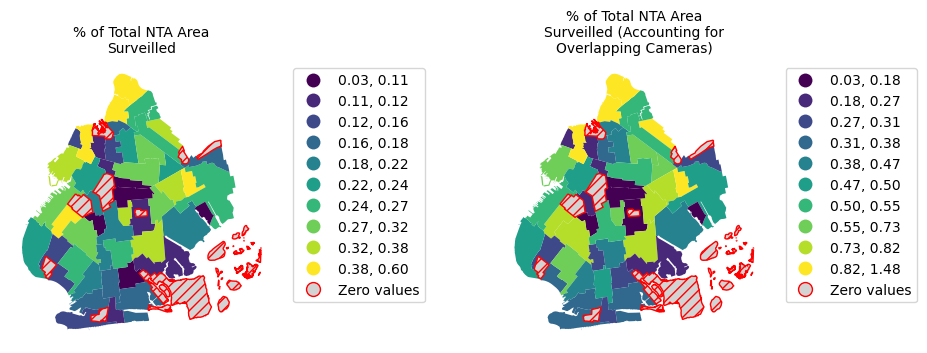

In [45]:
fig,ax = plt.subplots(1,2,figsize = (10,10))
nta_agg.plot(column='Proportion NTA Surveilled (Cum)', ax=ax[0], k=10, scheme='Quantiles', legend=True, 
              missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Zero values"},
              legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
ax[0].set_title('% of Total NTA Area\nSurveilled', fontdict={'fontsize': 10, 'multialignment': 'center'})
nta_agg.plot(column='Proportion NTA Surveilled (Cum & Mult)', ax=ax[1], k=10, scheme='Quantiles', legend=True, 
              missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Zero values"},
              legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
ax[1].set_title('% of Total NTA Area\nSurveilled (Accounting for\nOverlapping Cameras)', 
                 fontdict={'fontsize': 10, 'multialignment': 'center'})
fig.tight_layout()
ax[0].axis('off')
ax[1].axis('off')
plt.savefig('../Outputs/NTA_BK_CameraBuffer_200m_aggregates.png')

### notes for liz from 04/11 team meeting:

* include street area in denominator not NTA/Tract/Block area..

* Documentation while we do analysis

* color blind accessibility

* can we create a reverse buffer on the BBL shape file to account for surveilling private property

In [47]:
# create a new geodataframe consisting of the difference between bk_mappluto and bndy_gdf
diff_gdf = gpd.overlay(bk_mappluto, bk_ntas, how='difference')

# check the result
diff_gdf.head()

BBL  CondoNo   CD  BCT2020    BCTCB2020 CT2010 CB2010 SchoolDist  \
0  3.000050e+09        0  302  3002100  30021003000     21   3001         13   
1  3.000250e+09        0  302  3002100  30021001003     21   1006         13   
2  3.001990e+09        0  101  1001501  10015010002  15.01   0001       None   
3  3.001990e+09        0  302  3000100  30001001007      1   1004         13   
4  3.002450e+09        0  101  1000900  10009000001      9   0001       None   

   Council  ZipCode  XCoord  YCoord   Latitude  Longitude  Shape_Leng  \
0       33    11201  989346  196266  40.705380 -73.981620         0.0   
1       33    11201  985923  195722  40.703888 -73.993966         0.0   
2        1        0  985465  195481  40.703227 -73.995618         0.0   
3       33    11201  984779  194198  40.699705 -73.998092         0.0   
4        1        0  984004  192845  40.695992 -74.000887         0.0   

     Shape_Area                                           geometry  
0  1.208601e+05  MULTIPOLYGON (((-73.98202 40.70552, -73.98197 ...  
1  9.524603e+04  MULTIPOLYGON (((-73.99377 40.70445, -73.99377 ...  
2  5.440100e+01  MULTIPOLYGON (((-73.99509 40.70305, -73.99510 ...  
3  1.348501e+06  MULTIPOLYGON (((-73.99566 40.70246, -73.99585 ...  
4  7.935120e+03  MULTIPOLYGON (((-73.99960 40.69607, -73.99943 ...